<a href="https://colab.research.google.com/github/omar-shaaban742001/computer_vison_pytorch/blob/master/Transfer_learning_food_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Get the data

In [2]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (1244/1244), done.
remote: Compressing objects: 100% (242/242), done.
remote: Total 4056 (delta 1078), reused 1092 (delta 999), pack-reused 2812
Receiving objects: 100% (4056/4056), 651.60 MiB | 35.67 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [4]:
#setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#Get the small foodvision dataset


In [5]:
import os
from pathlib import Path
import zipfile
import requests

#setup the data directory
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#check if the directory is already exist
if image_path.is_dir():
  print(f"{image_path} is already exist")
else:
  #make the directory for image path
  image_path.mkdir(parents=True , exist_ok=True)

#downloading the dataset
with open(data_path / "pizza_steak_sushi.zip" , 'wb') as f:
  #request the data from github
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")

  print(f"Downloading pizza, steak and sushi dataset")

  #write the content in our directory
  f.write(request.content)

  #unzip the dataset
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip" , 'r') as zep_ref:
    print("unzipping the dataset")
    zep_ref.extractall(image_path)

unzipping the dataset


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
train_dir , test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

##Create Datasets and DataLoaders

# Creating a transform (manual)

In [8]:
# Create a transforms pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [9]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f978eaea470>,
 ['pizza', 'steak', 'sushi'])

##Creating a transform (Auto)

In [10]:
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
weights

EfficientNet_B1_Weights.IMAGENET1K_V2

In [11]:
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[240]
    resize_size=[255]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [12]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = auto_transform,
                                                                               batch_size = 32)
train_dataloader , test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f978eaeb670>,
 ['pizza', 'steak', 'sushi'])

In [13]:
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b1(weights=weights).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 83.9MB/s]


In [14]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:
from torchinfo import summary

summary(
    model = model,
    input_size = (1 , 3 , 224 , 224),
    col_names= ['input_size', 'output_size', 'num_params', 'trainable']
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        True
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Sequential: 2-2  

##Freazing the base layer

In [16]:
#loop through the base layers parameters and freeze them
for param in model.features.parameters():
  param.requires_grad = False


In [17]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [18]:
#change the model classifier for suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)


model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=3, bias=True)
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [19]:
summary(
    model = model,
    input_size = (1 , 3 , 224 , 224),
    col_names= ['input_size', 'output_size', 'num_params', 'trainable']
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 3]                    --                        Partial
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Sequential

##Train the model

In [20]:
#setup the loss function
loss_fn = nn.CrossEntropyLoss()

#set up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = .001)

In [21]:
from timeit import default_timer as timer
from going_modular.going_modular import engine

#setup manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#setup timer
start_time = timer()

#train the model
result = engine.train(model = model,
                      train_dataloader = train_dataloader,
                      test_dataloader = test_dataloader,
                      optimizer = optimizer,
                      loss_fn = loss_fn,
                      epochs= 5,
                      device = device)

end_time = timer()

print(f"The total time to train out model is {end_time - start_time}")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0791 | train_acc: 0.4727 | test_loss: 0.9888 | test_acc: 0.6932
Epoch: 2 | train_loss: 0.9534 | train_acc: 0.7383 | test_loss: 0.9190 | test_acc: 0.8769
Epoch: 3 | train_loss: 0.8730 | train_acc: 0.7734 | test_loss: 0.8432 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7851 | train_acc: 0.9492 | test_loss: 0.7722 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.7500 | train_acc: 0.8242 | test_loss: 0.7440 | test_acc: 0.8968
The total time to train out model is 14.094780661999948


In [22]:
try:
  from helper_function import plot_loss_curves
except:
  with open("helper_function.py" , "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)

  from helper_function import plot_loss_curves


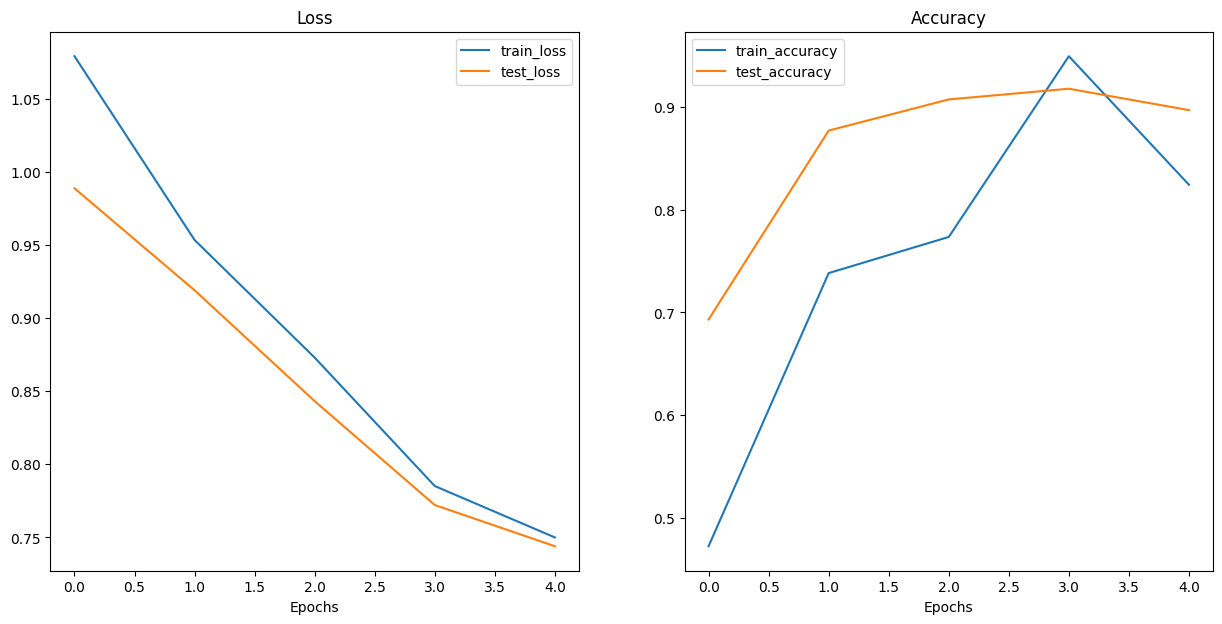

In [24]:
plot_loss_curves(result)

In [29]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure(figsize = (3 , 3))
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

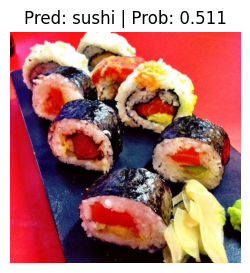

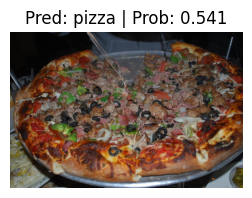

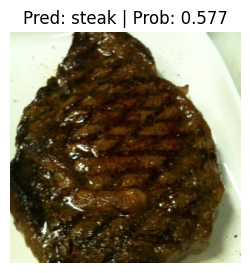

In [30]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

##Making predictions on a custom image

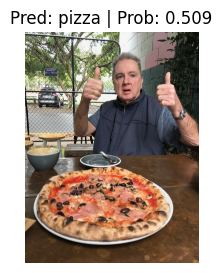

In [31]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)